In [1]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imsparsh/flowers-dataset")

print("Path to dataset files:", path)

100%|██████████| 205M/205M [00:01<00:00, 157MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2


In [2]:
from google.colab import drive
# Mount Google Drive to access files stored there
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random


### set the path of the dataset in google drive

In [4]:
print("Path to dataset files:", path)
print("Contents of the dataset directory:")
print(os.listdir(path))

Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2
Contents of the dataset directory:
['LICENSE.txt', 'Testing_set_flower.csv', 'sample_submission.csv', 'train', 'test']


In [5]:
import shutil

source_path = path
destination_path = '/content/drive/MyDrive/flowers-dataset'

os.makedirs(destination_path, exist_ok=True)
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print(f"Dataset successfully copied from {source_path} to {destination_path}")

Dataset successfully copied from /root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2 to /content/drive/MyDrive/flowers-dataset


In [6]:
destination_path = '/content/drive/MyDrive/flowers-dataset'
print(os.listdir(destination_path))

['LICENSE.txt', 'Testing_set_flower.csv', 'sample_submission.csv', 'train', 'test']


### Load and view the dataset

In [7]:
def preview(image_folder_path):
  # If the folder path does not exist, print an error and return empty lists and dictionaries
  if not os.path.exists(image_folder_path):
    print(f"Error: Folder not found at {image_folder_path}")
    return [], {}
  else:
    # If the folder path exists, list the subfolders
    class_folders = os.listdir(image_folder_path)

    dataset = []
    class_images = {}

    # Iterate through each class folder
    for i in class_folders:
      class_path = os.path.join(image_folder_path, i)
      if os.path.isdir(class_path):
        images_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        full_paths = [os.path.join(class_path, f) for f in images_files]
        dataset.extend([(path, i) for path in full_paths])                   # Extend the dataset list with image paths and their corresponding class labels
        class_images[i] = full_paths                                         # Store the image paths for each class in a dictionary

    print(f"Total images found in {image_folder_path}: {len(dataset)}")

    # Display a sample image from each class
    plt.figure(figsize = (12,6))
    for j, (i, paths) in enumerate(class_images.items()):
      if paths:
        sample_path = random.choice(paths)
        try:
          img = mpimg.imread(sample_path)
          plt.subplot(1, len(class_images), j + 1)
          plt.imshow(img)
          plt.title(i)
          plt.axis('off')
        except Exception as e:
          print(f"Error reading image: {e}")
    plt.show()
    # Return the dataset list and the class_images dictionary
    return dataset, class_images

Total images found in /content/drive/MyDrive/flowers-dataset/train: 2746


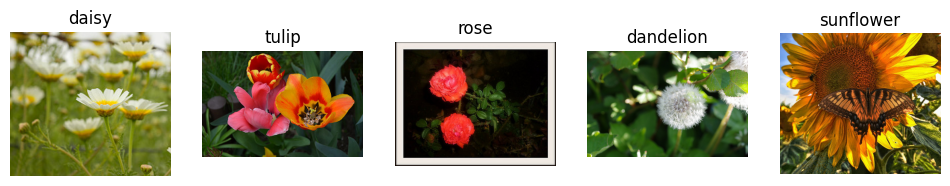

Total images found in /content/drive/MyDrive/flowers-dataset/test: 0


<Figure size 1200x600 with 0 Axes>

In [8]:
train_dataset, train_class_images = preview("/content/drive/MyDrive/flowers-dataset/train")
test_dataset, test_class_images = preview("/content/drive/MyDrive/flowers-dataset/test")

### Create the CNN with 1 convolutional layer and 2 hidden layers

In [9]:
import torch
import torch.nn as nn

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dropout = nn.Dropout(0.20)
    self.fc1 = nn.Linear(16 * 112 * 112, 128)
    self.bn2 = nn.BatchNorm1d(128)
    self.fc2 = nn.Linear(128, 5)

  def forward(self, x):
    x = self.pool(self.relu(self.bn1(self.conv1(x))))
    x = x.view(-1, 16 * 112 * 112)
    x = self.fc1(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [10]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### Create DataLoader to batch and train efficiently.

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class Flowers(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.class_to_idx = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        label_idx = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

image_size = 224
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),         # randomly flip an image, each image has 50% chance of being flipped
    transforms.ToTensor()])

train_dataset_obj = Flowers(train_dataset, transform=train_transforms)
batch_size = 32
train_loader = DataLoader(train_dataset_obj, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

print(f"Number of training batches: {len(train_loader)}")

Number of training batches: 86


### Train the model

In [12]:
device = torch.device("cuda")
print("Using device:", device)

model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # Added dropout, so my total loss should be less reliable
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Using device: cuda
Epoch [1/10], Loss: 1.2980
Epoch [2/10], Loss: 1.1417
Epoch [3/10], Loss: 1.0415
Epoch [4/10], Loss: 0.9728
Epoch [5/10], Loss: 0.8664
Epoch [6/10], Loss: 0.7813
Epoch [7/10], Loss: 0.6890
Epoch [8/10], Loss: 0.5645
Epoch [9/10], Loss: 0.4381
Epoch [10/10], Loss: 0.3685


### Test the model

Prediction on the training set:


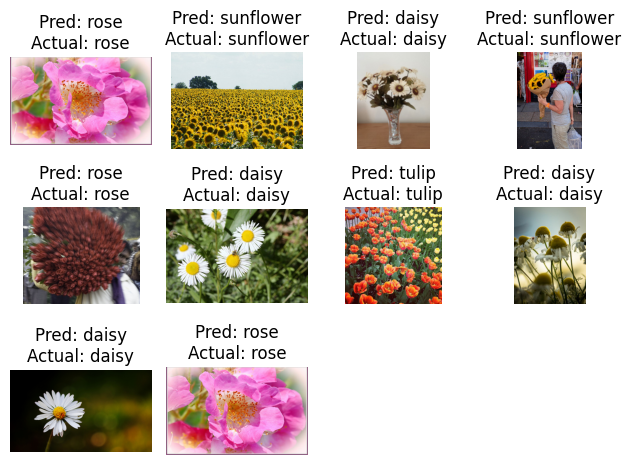

In [21]:
import random
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

for i in range(10):
  # Choose a random image from the test dataset
  random_index = random.randint(0, len(train_dataset_obj) - 1)
  image_path, actual_label = train_dataset_obj.data[random_index]
  image = Image.open(image_path).convert('RGB')

  # Preprocess the image
  image_size = 224
  preprocess = transforms.Compose([
      transforms.Resize((image_size, image_size)),
      transforms.ToTensor(),
  ])
  image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

  image_tensor = image_tensor.to(device)

  # Make a prediction
  model.eval()
  with torch.no_grad():
      outputs = model(image_tensor)
      _, predicted_idx = torch.max(outputs.data, 1)

  idx_to_class = {v: k for k, v in train_dataset_obj.class_to_idx.items()}
  predicted_label = idx_to_class[predicted_idx.item()]


  # Show in subplot
  plt.subplot(3, 4, i+1)  # 2 rows, 5 columns, index starts at 1
  plt.imshow(image)
  plt.title(f"Pred: {predicted_label}\nActual: {actual_label}")
  plt.axis('off')

print("Prediction on the training set:")
plt.tight_layout()
plt.show()

Prediction on one image in the test dataset:


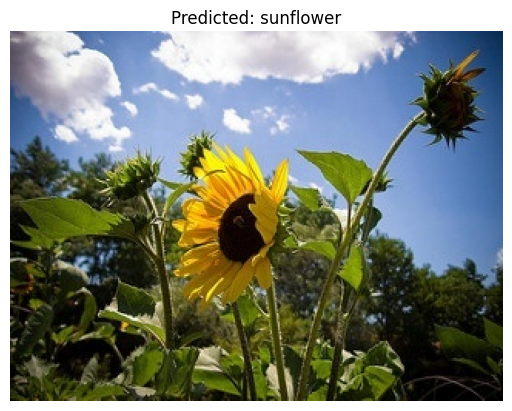

The model predicted: sunflower


In [22]:
test = "/content/drive/MyDrive/flowers-dataset/test/Image_101.jpg"

# Choose a random image from the test dataset
image_path = test
image = Image.open(image_path).convert('RGB')

# Preprocess the image
image_size = 224
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])
image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

image_tensor = image_tensor.to(device)

# Make a prediction
model.eval()
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_idx = torch.max(outputs.data, 1)

idx_to_class = {v: k for k, v in train_dataset_obj.class_to_idx.items()}
predicted_label = idx_to_class[predicted_idx.item()]


print("Prediction on one image in the test dataset:")
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

print(f"The model predicted: {predicted_label}")

Prediction on multiple images in the test dataset


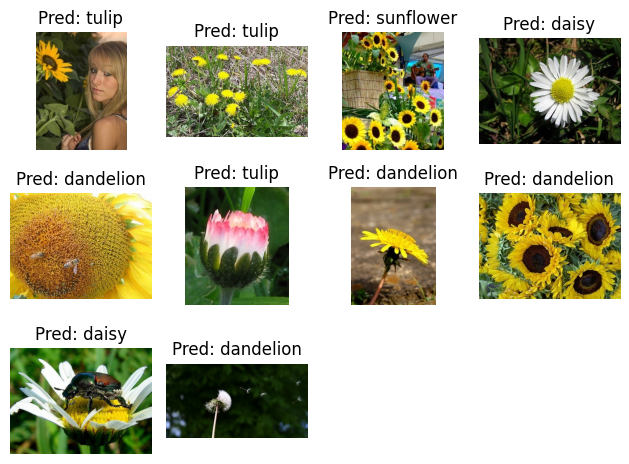

In [23]:
test = "/content/drive/MyDrive/flowers-dataset/test/Image_105.jpg"

import re

for i in range(10):
  # Replace the number with a new one (e.g. 102)
  new_test = re.sub(r"(\d+)", lambda m: str(int(m.group(1)) + i), test)


  # Choose a random image from the test dataset
  image_path = new_test
  image = Image.open(image_path).convert('RGB')

  # Preprocess the image
  image_size = 224
  preprocess = transforms.Compose([
      transforms.Resize((image_size, image_size)),
      transforms.ToTensor(),
  ])
  image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

  image_tensor = image_tensor.to(device)

  # Make a prediction
  model.eval()
  with torch.no_grad():
      outputs = model(image_tensor)
      _, predicted_idx = torch.max(outputs.data, 1)

  idx_to_class = {v: k for k, v in train_dataset_obj.class_to_idx.items()}
  predicted_label = idx_to_class[predicted_idx.item()]


  # Show in subplot
  plt.subplot(3, 4, i+1)  # 2 rows, 5 columns, index starts at 1
  plt.imshow(image)
  plt.title(f"Pred: {predicted_label}")
  plt.axis('off')

print("Prediction on multiple images in the test dataset")
plt.tight_layout()
plt.show()